<h1 align=center><font size = 5>Capstone Project - The Battle of Neighborhoods</font></h1>
 

<h2 align=left><font size = 4>An Analysis of Postal Zones in Montgomery County, Maryland</font></h2> 


## 1. Introduction <a name="introduction"></a>

Montgomery County is the most populous county in the U.S. state of Maryland, located adjacent to Washington, D.C.. It is an important business and research center. Most of the county's residents live in unincorporated locales, of which the most urban are Silver Spring and Bethesda, although the incorporated cities of Rockville and Gaithersburg are also large population centers, as are many smaller but significant places (Wikipedia).

Eric is a biological scientist who is moving to Maryland from California due to the relocation of his job. The Montgomery County is a good choice because of the comfortable distance for Eric commutes to work. However, Eric is not familiar with the neighborhoods and house market as a newcomer from western coast. After an interview with Eric and his family, I learned that Eric is living with his wife and two teenage boys. And they expected to live in an urban neighborhood with grocery stores, gyms, favorite restaurants and theater for a convenient life. And park is also important for Eric's family to enjoy the weekend time. In addition, their budget for this new house in Montgomery is 1 million.  

To help Eric start the house hunting easily, I designed this project to let him know the house market and common feathers in each postal zone of Montgomery county quickly. To explore the housing market and living environment, I collected the geographic data, common venue data, and average housing values of each zip code. A then, I utilized machine learning algorithm to conduct data exploratory analysis and clustering analysis, and used the Folium library to visualize the postal zones in Montgomery county and their emerging clusters. Finally, I got three most promising postal zones for Eric's family. I think the project can assist other people who have the similar background and needs as Eric to find a good neighborhood in Montgomery county.


## 2. Data Preparation <a name="data"></a>



In this section, I introduced the data source and data collection. To develop the model, I collected geographic data, venue category data and housing price data of Montgomery county through web scraping and downloading. To create the dataframe used for the analysis, I also did some data cleaning and data modification which will be shown in the following coding scripts. 

### 2.1 Description of Data and Data Source

* **Zip Codes** and City Names in Montgomery County, Maryland
    * The data is gathered through web scraping from https://www.zip-codes.com/county/md-montgomery.asp
    * This data provides the Zip codes information
    <br/><br/>
* Demographic and Housing Data 
    * Latitude and Longitude
        * The coordinates can locate each postal area and combine with venues data to explore the venue information
    * Average House Price
        * The average house price of each postal area will be considered by Eric to make final decision
    * Zip Codes
    * The data is gathered through web scraping from https://www.zip-codes.com/county/md-montgomery.asp and the nested link for each zip code.
    * Some modification and data cleaning is processed in this section
    * This data can locate the position of each Zip Code in Montgomery county
    <br/><br/>
* Montgomery County's GeoJSON with Zip Codes and other information
    * The GeoJSON file of Montgomery is downloaded from https://data.montgomerycountymd.gov/Technology/Geographic-data-Zip-Codes-Shape-File-/vz4m-d8ee
    * The data provides the map layer with zip codes in Montgomery County, MD.
    <br/><br/>
* Venues 
    * The data is gathered from web scraping through Foursquare API
    * The Foursquare location data provides venues information and categories


### Library Setup

In [6]:
# !pip install geocoder
#pip install opencage
# !pip install conda
# !conda install -c conda-forge folium --yes
# !conda install -c conda-forge geopy --yes
#!pip install folium
#from opencage.geocoder import OpenCageGeocode
#!conda update conda


In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium # map rendering library
from folium import plugins

# import k-means from clustering stage
from sklearn.cluster import KMeans



print('Libraries imported.')

Libraries imported.


## 2.2 Data Collection and Processing

In order to segment and explore the neighborhoods, I essentially need a dataset that contains all zip codes in Montgomery county, MD as well as the the latitude and longitude coordinates of each postal area.

### 2.2.1 Zip Codes Data

In [2]:
# set up the url and scrape from website
url = 'https://www.zip-codes.com/county/md-montgomery.asp'
r = requests.get(url)
data = r.text
soup = BeautifulSoup(data)

# The table with zip codes and cities information in html file
table=soup.table.find_all('a')

In [3]:
# create the data frame with zip codes
column_name=['ZipCode','City','State']
zip_table=pd.DataFrame(columns=column_name)
zip_table

,ZipCode,City,State


In [4]:
# A loop to get zip codes and city names
for i in list(range(34,187)):
    #row_data=[]
    if i%2==0:
        #print (table[i]['title'].split(','))
        zip_table.loc[str((i-34)/2)]=table[i]['title'][9:].split(',')

zip_table=zip_table.reset_index().drop(['index'],axis=1)
        

In [5]:
# zip code and city name table
zip_table.head()

,ZipCode,City,State
0,20810,BETHESDA,MD
1,20811,BETHESDA,MD
2,20812,GLEN ECHO,MD
3,20813,BETHESDA,MD
4,20814,BETHESDA,MD


In [6]:
print ('There are {} ZIP Codes in Montgomery County, MD'.format(zip_table.shape[0]))

There are 77 ZIP Codes in Montgomery County, MD


### 2.2.2  Demographic Data and Housing Data

In [7]:
# Create data frame with demographic information and average housing values
column_name_demo=['ZipCode','Latitude','Longitude','Avg_House_Val']
demographic_table=pd.DataFrame(columns=column_name_demo)
demographic_table

,ZipCode,Latitude,Longitude,Avg_House_Val


In [8]:
# to get the zip code list 
zip_list=zip_table['ZipCode']

# to scrape demographic data of each postal area
for zip_code in zip_list:
    row_data=[]
    
    url_demo = 'https://www.zip-codes.com/zip-code/{}/zip-code-{}.asp'.format(zip_code,zip_code)
    #print (url_demo)
    r_demo=requests.get(url_demo).text
    soup_demo = BeautifulSoup(r_demo)
    
    
    table_demo = soup_demo.table.find_all('tr')[0].find_all('table')
    
    zipc=table_demo[0].find_all('tr')[0].find_all('td')[-1].text.strip()
    latitude=table_demo[0].find_all('tr')[11].find_all('td')[-1].text.strip()
    longitude = table_demo[0].find_all('tr')[12].find_all('td')[-1].text.strip()
    
    #num_household = table_demo[1].find_all('tr')[2].find_all('td')[-1].text.strip()
    avg_house_val = table_demo[1].find_all('tr')[3].find_all('td')[-1].text.strip()[1:]
    #avg_inc = table_demo[1].find_all('tr')[4].find_all('td')[-1].text.strip()[1:]
    
    row_data=[zipc,latitude,longitude,avg_house_val]#,num_household,avg_inc]
    #print (row_data)
    
    demographic_table.loc[len(demographic_table)]=row_data    
    

In [9]:
# demographic_table
demographic_table.head()

,ZipCode,Latitude,Longitude,Avg_House_Val
0,20810,Yes,38.9806,0
1,20811,Yes,38.9806,0
2,20812,38.968422,-77.14235,"898,000"
3,20813,38.9806,-77.1008,0
4,20814,39.004804,-77.102477,"759,100"


In [10]:
demographic_table.shape

(77, 4)

In [11]:
# merge the two tables above
df_all=pd.merge(zip_table,demographic_table, on='ZipCode')
df_all.head()

,ZipCode,City,State,Latitude,Longitude,Avg_House_Val
0,20810,BETHESDA,MD,Yes,38.9806,0
1,20811,BETHESDA,MD,Yes,38.9806,0
2,20812,GLEN ECHO,MD,38.968422,-77.14235,"898,000"
3,20813,BETHESDA,MD,38.9806,-77.1008,0
4,20814,BETHESDA,MD,39.004804,-77.102477,"759,100"


In [12]:
df_all.shape

(77, 6)

In [13]:
# drop the row (zip code) with $0 average house value 
df_wo_null=df_all[(df_all['Avg_House_Val']!='0')] #& df_all['Num_Household']!='0') & (df_all['Avg_Inc_Per_Household']!='0')]
df_wo_null=df_wo_null.reset_index().drop(['index'], axis=1)

In [14]:
df_wo_null.head()

,ZipCode,City,State,Latitude,Longitude,Avg_House_Val
0,20812,GLEN ECHO,MD,38.968422,-77.14235,"898,000"
1,20814,BETHESDA,MD,39.004804,-77.102477,"759,100"
2,20815,CHEVY CHASE,MD,Yes,38.984212,"985,700"
3,20816,BETHESDA,MD,38.95397,-77.135482,"939,700"
4,20817,BETHESDA,MD,39.003314,-77.159528,"893,300"


### Data Cleaning

There are 10 rows of data having mistakes in column Latitude and column Longitude. As I investigated the HTML scripts, I found the demographic data in these 10 postal areas are in different rows of the data. I re-pulled the Latitude and Longitude information for them and corrected the mistakes in table.

In [15]:
# Correct the rows with 'Yes' in Column Latitude, and latitude number in Longitude
temp = df_wo_null

zip_w_wrong_geo=df_wo_null.loc[df_wo_null['Latitude']=='Yes']['ZipCode']
zip_w_wrong_geo.reset_index().drop('index',axis=1)

for wrong in zip_w_wrong_geo:
    print (wrong)
    temp.loc[temp['ZipCode']==wrong, 'Latitude'] = temp['Longitude']  
    
    url_corr = 'https://www.zip-codes.com/zip-code/{}/zip-code-{}.asp'.format(wrong,wrong)
    #print (url_demo)
    r_corr=requests.get(url_corr).text
    soup_corr = BeautifulSoup(r_corr)
    
    table_corr = soup_corr.table.find_all('tr')[0].find_all('table')
    longitude_corr = table_corr[0].find_all('tr')[13].find_all('td')[-1].text.strip()
    
    temp.loc[temp['ZipCode'] == wrong, 'Longitude']= longitude_corr

df_corr = temp

20815
20833
20842
20852
20895
20903
20904
20905
20906
20910


In [16]:
# correct dataframe
df_corr.head()

,ZipCode,City,State,Latitude,Longitude,Avg_House_Val
0,20812,GLEN ECHO,MD,38.968422,-77.14235,"898,000"
1,20814,BETHESDA,MD,39.004804,-77.102477,"759,100"
2,20815,CHEVY CHASE,MD,38.984212,-77.079106,"985,700"
3,20816,BETHESDA,MD,38.95397,-77.135482,"939,700"
4,20817,BETHESDA,MD,39.003314,-77.159528,"893,300"


In [17]:
df_corr.shape

(43, 6)

In [18]:
# transform data types

import locale

df_corr['Latitude']=pd.to_numeric(df_corr['Latitude'])
df_corr['Longitude']=pd.to_numeric(df_corr['Longitude'])
df_corr['ZipCode']=df_corr['ZipCode'].astype(int)
#df_corr.head()

locale.setlocale(locale.LC_ALL, 'en_US.UTF-8' ) 
temp_num=df_corr

for i in list(range(0,43)):
#    locale.atoi(temp_num['Num_Household'][i])
    locale.atoi(temp_num['Avg_House_Val'][i])
#    locale.atoi(temp_num['Avg_Inc_Per_Household'][i])
# 1000000
#    temp_num['Num_Household'][i] = locale.atof(temp_num['Num_Household'][i])
    temp_num['Avg_House_Val'][i] = locale.atof(temp_num['Avg_House_Val'][i])
#    temp_num['Avg_Inc_Per_Household'][i] = locale.atof(temp_num['Avg_Inc_Per_Household'][i])


df=temp_num


<ipython-input-18-a6d33f3473f4>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_num['Avg_House_Val'][i] = locale.atof(temp_num['Avg_House_Val'][i])


In [19]:
df.head()

,ZipCode,City,State,Latitude,Longitude,Avg_House_Val
0,20812,GLEN ECHO,MD,38.968422,-77.142350,898000
1,20814,BETHESDA,MD,39.004804,-77.102477,759100
2,20815,CHEVY CHASE,MD,38.984212,-77.079106,985700
3,20816,BETHESDA,MD,38.953970,-77.135482,939700
4,20817,BETHESDA,MD,39.003314,-77.159528,893300


### 2.2.3 GeoJSON file with zip codes in Montgomery

In [20]:
# geojson file with zip codes in montgomery county in Maryland
montgomery_geo = r'Geo_data_zipcodes.geojson' 

In [7]:
# read the GeoJSON file
import json
with open(montgomery_geo) as f:
    data = json.load(f)  
data['features']

### 2.2.3 Venues Data from Foursquare API

In [22]:
# get Foursquare API url
CLIENT_ID = '3HG1DE1EB0MICKFTH4FDIGVGLLDVPQVHIQKY210TC544AHDH' # your Foursquare ID
CLIENT_SECRET = 'GVFTB2UV3BN2UG1WEC3IYF0ERIXP4XXBEIKV15HULHZWLBFS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3HG1DE1EB0MICKFTH4FDIGVGLLDVPQVHIQKY210TC544AHDH
CLIENT_SECRET:GVFTB2UV3BN2UG1WEC3IYF0ERIXP4XXBEIKV15HULHZWLBFS


In [23]:
def getNearbyVenues(zipcodes, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for zipcode, lat, lng in zip(zipcodes, latitudes, longitudes):
        #print(zipcode)          
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCode', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
montgomery_venues = getNearbyVenues(zipcodes=df['ZipCode'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [25]:
montgomery_venues.head()

,ZipCode,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,20812,38.968422,-77.14235,Adventure Theatre MTC,38.965779,-77.137865,Theater
1,20812,38.968422,-77.14235,Glen Echo Park,38.967584,-77.139559,Park
2,20812,38.968422,-77.14235,Glen Echo Spanish Ballroom,38.965571,-77.138895,Rock Club
3,20812,38.968422,-77.14235,Chataqua Lock (Lock #7),38.964482,-77.138290,Trail
4,20812,38.968422,-77.14235,Clara Barton National Historic Site,38.968019,-77.139413,History Museum


In [26]:
montgomery_venues.shape

(1727, 7)

In [27]:
montgomery_venues.groupby('ZipCode').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
ZipCode,,,,,,
20812,29,29,29,29,29,29
20814,69,69,69,69,69,69
20815,89,89,89,89,89,89
20816,34,34,34,34,34,34
20817,17,17,17,17,17,17
20818,26,26,26,26,26,26
20832,46,46,46,46,46,46
20833,7,7,7,7,7,7
20837,4,4,4,4,4,4


In [28]:
print ('There are {} categories in all venues'.format(len(montgomery_venues['Venue Category'].unique())))

There are 246 categories in all venues


## 2.3 Data Visulization

### 2.3.1 **Visulize the *Average House Price* in Montgomery County, MD**

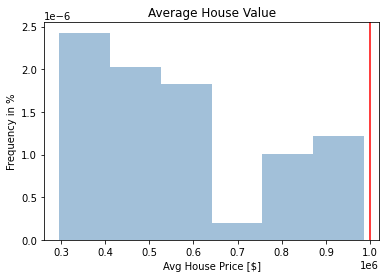

In [29]:
## Visulize the Average House Price in Montgomery County, MD

plt.ylabel('Frequency in %')
plt.xlabel('Avg House Price [$]')
plt.title('Average House Value')

plt.hist(df['Avg_House_Val'], bins=6, density=True, alpha=0.5, 
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
plt.axvline(1000000, 0,1, color='red')

The red line is Eric's budget of $1 million for his new house, which is higher than any average house price in any postal zone.

### 2.3.2 Visulize the Average House Value in each Postal Zone 

In [30]:
# Use geopy library to get the geographical coordinate of Montgomery county
address = 'Montgomery, MD'

geolocator = Nominatim(user_agent="md_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Montgomery are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Montgomery are 39.1406267, -77.2075612.


In [31]:
# convert data type of zip codes to string
df['ZipCode']=df['ZipCode'].astype(str)

In [1]:
# create a numpy array of length 6 and has linear spacing from the minium average house value to the maximum average house value
threshold_scale = np.linspace(df['Avg_House_Val'].min(),
                              df['Avg_House_Val'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration
# let Folium determine the scale.

# create a plain house value map
house_val_map = folium.Map(location=[latitude, longitude], zoom_start=10)

choropleth = folium.Choropleth(
    geo_data=montgomery_geo,
    data=df,
    columns=['ZipCode','Avg_House_Val'],
    key_on='feature.properties.zipcode',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average House Price',
    reset=True
).add_to(house_val_map)

choropleth.geojson.add_child(
     folium.features.GeoJsonTooltip(['zipcode'], labels=False))


# display map
house_val_map

As we can see from the map, the average house value were divided into 5 groups from high to low. And the black zone is the zip codes we dropped from data collection section due to the $0 value of average house price. It is possible that there is no population or no commercial houses in these postal zones.

### 2.4.3 Visulize the Venues 

In [2]:
# create map of Montgomery using latitude and longitude values
map_montgomery_venues = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(montgomery_venues['Venue Latitude'], montgomery_venues['Venue Longitude'], montgomery_venues['ZipCode']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='Blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_montgomery_venues)  
    
map_montgomery_venues

The blue circles on the map 3 present the venue coordinates in Montgomery county and the venues include categories such as Parks, Grocery Stores, Restaurants, etc.

# 3. Methodology <a name="methodology"></a>

I started with an exploratory data analysis to investigate the postal areas finding out the area with most of Eric's preferred venues categories. And then, I used the K-means clustering to segment the postal areas to select the neighborhoods similar to the one above. 

## 3.1 Exploratory Data Analysis

### 3.1.1 Analyze Each Postal Area

In this section, I generated the table of top 10 common venue categories of each postal zone to give Eric a review of each neighborhood. 

In [34]:
# one hot encoding
montgomery_venues_onehot = pd.get_dummies(montgomery_venues[['Venue Category']], prefix="", prefix_sep="")
montgomery_venues_onehot['ZipCode'] = montgomery_venues['ZipCode'] 

#move ZipCode column to the first
fixed_columns = [montgomery_venues_onehot.columns[-1]] + list(montgomery_venues_onehot.columns[:-1])
montgomery_venues_onehot = montgomery_venues_onehot[fixed_columns]

montgomery_venues_onehot.head()

,ZipCode,ATM,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Store,Big Box Store,Bike Trail,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Campground,Caribbean Restaurant,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,City Hall,Clothing Store,Coffee Shop,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Credit Union,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dam,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Service,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lingerie Store,Liquor Store,Locksmith,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Noodle House,Nursery School,Office,Optical Shop,Other Great Outdoors,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Pool,Portuguese Restaurant,Post Office,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Stables,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Town Hall,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,20812,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,

In [35]:
montgomery_venues_onehot.shape

(1727, 247)

In [36]:
#Group the dataframe based on the neigborhood and calculate the mean of the specific venue within this neigborhood
montgomery_venues_grouped = montgomery_venues_onehot.groupby('ZipCode').mean().reset_index()
montgomery_venues_grouped.head()

,ZipCode,ATM,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Store,Big Box Store,Bike Trail,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Campground,Caribbean Restaurant,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,City Hall,Clothing Store,Coffee Shop,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Credit Union,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dam,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Service,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lingerie Store,Liquor Store,Locksmith,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Noodle House,Nursery School,Office,Optical Shop,Other Great Outdoors,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Pool,Portuguese Restaurant,Post Office,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Stables,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Town Hall,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,20812,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.034483,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.034483,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZipCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
montgomery_venues_sorted = pd.DataFrame(columns=columns)
montgomery_venues_sorted['ZipCode'] = montgomery_venues_grouped['ZipCode']

for ind in np.arange(montgomery_venues_grouped.shape[0]):
    montgomery_venues_sorted.iloc[ind, 1:] = return_most_common_venues(montgomery_venues_grouped.iloc[ind, :], num_top_venues)

montgomery_venues_sorted.head()

,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,20812,Trail,History Museum,Park,National Park,Theater,Playground,Fast Food Restaurant,Bridge,Sandwich Place,Rock Club
1,20814,American Restaurant,Park,Pizza Place,Gym,Hotel,Intersection,Sandwich Place,Mexican Restaurant,Fast Food Restaurant,Diner
2,20815,Park,Mexican Restaurant,Trail,Grocery Store,Pizza Place,Bakery,Golf Course,Seafood Restaurant,Salad Place,Portuguese Restaurant
3,20816,Trail,Park,History Museum,Sandwich Place,Theater,Japanese Restaurant,Fast Food Restaurant,Martial Arts School,Bookstore,Stables
4,20817,Intersection,Golf Course,Pool,Tennis Court,Trail,Garden Center,Plaza,Spiritual Center,Baseball Field,Ice Cream Shop


In [39]:
montgomery_venues['ZipCode']=montgomery_venues['ZipCode'].astype(str)
montgomery_full_info = pd.merge(df, montgomery_venues, on='ZipCode')
montgomery_full_info = montgomery_full_info.drop(['Latitude_y','Longitude_y'],axis=1)
montgomery_full_info.rename(columns={'Latitude_x': 'Latitude', 'Longitude_x':'Longitude'},inplace=True)
montgomery_full_info.head()

,ZipCode,City,State,Latitude,Longitude,Avg_House_Val,Venue,Venue Latitude,Venue Longitude,Venue Category
0,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Adventure Theatre MTC,38.965779,-77.137865,Theater
1,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Glen Echo Park,38.967584,-77.139559,Park
2,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Glen Echo Spanish Ballroom,38.965571,-77.138895,Rock Club
3,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Chataqua Lock (Lock #7),38.964482,-77.138290,Trail
4,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Clara Barton National Historic Site,38.968019,-77.139413,History Museum


In [40]:
montgomery_full_info.shape

(1727, 10)

#### The map shows all zip codes and venues information

In [3]:
# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(montgomery_full_info['Avg_House_Val'].min(),
                              montgomery_full_info['Avg_House_Val'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration
# let Folium determine the scale.

full_map = folium.Map(location=[latitude, longitude], zoom_start=10)

choropleth = folium.Choropleth(
    geo_data=montgomery_geo,
    data=montgomery_full_info,
    columns=['ZipCode','Avg_House_Val'],
    threshold_scale=threshold_scale,
    key_on='feature.properties.zipcode',#zipcode
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average House Price',
).add_to(full_map)

choropleth.geojson.add_child(
     folium.features.GeoJsonTooltip(['zipcode'], labels=False))


# add markers to map
for lat, lng, label in zip(montgomery_full_info['Venue Latitude'], montgomery_full_info['Venue Longitude'], montgomery_full_info['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='black',
        fill_opacity=0.01,
        parse_html=False).add_to(full_map)  
    
# display map    
full_map


The map above shows the distribution of venues in each zip code. 

In [42]:
montgomery_full_info.head()

,ZipCode,City,State,Latitude,Longitude,Avg_House_Val,Venue,Venue Latitude,Venue Longitude,Venue Category
0,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Adventure Theatre MTC,38.965779,-77.137865,Theater
1,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Glen Echo Park,38.967584,-77.139559,Park
2,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Glen Echo Spanish Ballroom,38.965571,-77.138895,Rock Club
3,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Chataqua Lock (Lock #7),38.964482,-77.138290,Trail
4,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Clara Barton National Historic Site,38.968019,-77.139413,History Museum


In [106]:
#montgomery_full_info['Venue Category'].unique()

### 3.1.2 Analyze Areas with Preferred Categories

The following is the list of venue categories Eric's family prefers:
* Grocery Store
* Park
* Gym / Fitness Center
* Pizza Place, Mexican Restaurant, Italian Restaurant
* Theater

I explored the data with the venue categories above.

In [43]:
# dataset with preferred categories

data_cate = montgomery_full_info[
           (montgomery_full_info['Venue Category']=='Park') | (montgomery_full_info['Venue Category']=='Gym / Fitness Center') 
         | (montgomery_full_info['Venue Category']=='Grocery Store') | (montgomery_full_info['Venue Category']=='Theater')
         | (montgomery_full_info['Venue Category']=='Pizza Place') | (montgomery_full_info['Venue Category']=='Italian Restaurant')
         | (montgomery_full_info['Venue Category']=='Mexican Restaurant')
] 
                            
data_cate=data_cate.reset_index().drop(['index'], axis=1)

data_cate.head()

,ZipCode,City,State,Latitude,Longitude,Avg_House_Val,Venue,Venue Latitude,Venue Longitude,Venue Category
0,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Adventure Theatre MTC,38.965779,-77.137865,Theater
1,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Glen Echo Park,38.967584,-77.139559,Park
2,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,The Puppet Co. At Glen Echo Park,38.966164,-77.138364,Theater
3,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Fish Taco,38.974990,-77.162665,Mexican Restaurant
4,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Wild Tomato,38.974905,-77.162457,Pizza Place


In [44]:
data_cate.shape

(307, 10)

In [45]:
# assign different colors to different categories
color = ['purple','blue', 'black','green','pink', 'red','olive']
category = ['Park','Pizza Place','Grocery Store','Gym / Fitness Center','Theater','Mexican Restaurant','Italian Restaurant']#,'Outdoors & Recreation']#,'Parks']

for i in list(range(0,7)):
        data_cate.loc[data_cate['Venue Category']==category[i],'color']=color[i]

data_cate.head()       

,ZipCode,City,State,Latitude,Longitude,Avg_House_Val,Venue,Venue Latitude,Venue Longitude,Venue Category,color
0,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Adventure Theatre MTC,38.965779,-77.137865,Theater,pink
1,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Glen Echo Park,38.967584,-77.139559,Park,purple
2,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,The Puppet Co. At Glen Echo Park,38.966164,-77.138364,Theater,pink
3,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Fish Taco,38.974990,-77.162665,Mexican Restaurant,red
4,20812,GLEN ECHO,MD,38.968422,-77.14235,898000,Wild Tomato,38.974905,-77.162457,Pizza Place,blue


#### Visulize the preferred categories in each postal area

In [4]:

cate_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(cate_map)


choropleth = folium.Choropleth(
                 geo_data=montgomery_geo,
                 data=montgomery_full_info,
                 columns=['ZipCode','Avg_House_Val'], #City
                 threshold_scale=threshold_scale,
                 key_on='feature.properties.zipcode',#mail_city
                 fill_color='YlOrRd', 
                 fill_opacity=0.7, 
                 line_opacity=0.2,
                 legend_name='Average House Price',
              ).add_to(cate_map)


choropleth.geojson.add_child(
     folium.features.GeoJsonTooltip(['zipcode'], labels=False)) #mail_city
  

#add circles in the colors associated with the defined range
for index, row in data_cate.iterrows():
    folium.CircleMarker([row['Venue Latitude'], 
                         row['Venue Longitude']],
                         radius=2, 
                         color=row['color'], 
                         fill=True,
                         fill_color=row['color'],
                         fill_opacity=0.5,
                         popup=row['Venue Category']                    
                       ).add_to(cate_map)


# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(data_cate['Venue Latitude'], data_cate['Venue Longitude'], data_cate['Venue Category']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)
    
cate_map

The different colort in the map displayed different preferred categories in each postal zone. And from the numbers in the big circle, we can have a understanding of the # of common venues in an area.  

#### I created a list of the total # of preferred categories in each zip code and combined it with the correspondent average house price in each postal zone.

In [48]:
# one hot encoding
data_cate_onehot = pd.get_dummies(data_cate[['Venue Category']], prefix="", prefix_sep="")
data_cate_onehot['ZipCode'] = data_cate['ZipCode'] 

#move ZipCode column to the first
fixed_columns = [data_cate_onehot.columns[-1]] + list(data_cate_onehot.columns[:-1])
data_cate_onehot = data_cate_onehot[fixed_columns]

data_cate_onehot.head()

,ZipCode,Grocery Store,Gym / Fitness Center,Italian Restaurant,Mexican Restaurant,Park,Pizza Place,Theater
0,20812,0,0,0,0,0,0,1
1,20812,0,0,0,0,1,0,0
2,20812,0,0,0,0,0,0,1
3,20812,0,0,0,1,0,0,0
4,20812,0,0,0,0,0,1,0


In [49]:
data_cate_sum=data_cate_onehot.groupby('ZipCode').sum()
data_cate_sum.reset_index(inplace=True)
data_cate_sum["Total PreCate"] = data_cate_sum.sum(axis=1)
data_cate_sum.head()


,ZipCode,Grocery Store,Gym / Fitness Center,Italian Restaurant,Mexican Restaurant,Park,Pizza Place,Theater,Total PreCate
0,20812,1,1,1,1,2,1,2,9
1,20814,1,1,1,2,6,3,1,15
2,20815,3,2,1,4,6,3,1,20
3,20816,0,1,0,0,4,0,2,7
4,20818,1,1,1,1,2,1,0,7


In [54]:
# Table of total # of preferred Venue Categories and house price
pre_cate_merge=pd.merge(df,data_cate_sum,on='ZipCode')
pre_cate_merge.sort_values(by='Total PreCate', ascending=False).head(5)


,ZipCode,City,State,Latitude,Longitude,Avg_House_Val,Grocery Store,Gym / Fitness Center,Italian Restaurant,Mexican Restaurant,Park,Pizza Place,Theater,Total PreCate
2,20815,CHEVY CHASE,MD,38.984212,-77.079106,985700,3,2,1,4,6,3,1,20
36,20910,SILVER SPRING,MD,39.003350,-77.035444,556000,3,1,1,5,4,3,0,17
31,20902,SILVER SPRING,MD,39.041070,-77.045049,392100,3,1,1,2,5,5,0,17
37,20912,TAKOMA PARK,MD,38.982635,-77.003887,518400,3,0,0,1,5,6,0,15
1,20814,BETHESDA,MD,39.004804,-77.102477,759100,1,1,1,2,6,3,1,15


Table above includes the number of Eric’s each preferred venue category and a total number of preferred categories. From the top 5 postal zones, the 20815 has the greatest number of preferred categories Eric’s family expect for and the house price is closest to their budget. And 20814 is the second one that has all these seven preferred categories. 
And then, I utilized the K-means clustering algorithm to segment the postal areas and try to find some other similar areas. 

## 3.2 K-means Clustering Analysis

K-means clustering analysis is vastly used for clustering in many data science applications, especially useful if you need to quickly discover insights from unlabeled data.

In [55]:
# dataset for K-means clustering analysis
cluster_dataset = montgomery_venues_grouped
cluster_dataset.head()

,ZipCode,ATM,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Store,Big Box Store,Bike Trail,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Campground,Caribbean Restaurant,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,City Hall,Clothing Store,Coffee Shop,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Credit Union,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dam,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Service,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lingerie Store,Liquor Store,Locksmith,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Noodle House,Nursery School,Office,Optical Shop,Other Great Outdoors,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Pool,Portuguese Restaurant,Post Office,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Stables,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Town Hall,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,20812,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.034483,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.034483,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0

In [56]:
## Elbow method for optimal K 
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster_dataset)
    Sum_of_squared_distances.append(km.inertia_)

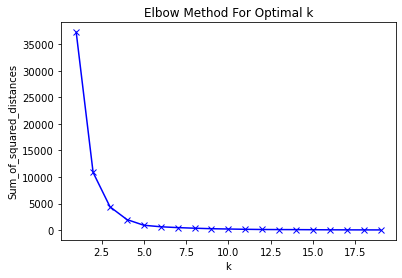

In [57]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# Optimal number of cluster is 5

In [58]:
# set number of clusters
num_clusters = 5

# run k-means clustering
k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

# check cluster labels generated for each row in the dataframe
print(labels)

[1 1 1 1 1 1 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3
 3 3 3 3 3 3]


In [59]:
cluster_dataset["Labels"] = labels
cluster_dataset.head()

,ZipCode,ATM,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Store,Big Box Store,Bike Trail,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Campground,Caribbean Restaurant,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,City Hall,Clothing Store,Coffee Shop,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Credit Union,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dam,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Service,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lingerie Store,Liquor Store,Locksmith,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Noodle House,Nursery School,Office,Optical Shop,Other Great Outdoors,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Pool,Portuguese Restaurant,Post Office,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Stables,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Town Hall,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Labels
0,20812,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.034483,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.034483,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0

In [60]:
cluster_dataset.groupby('Labels').mean()

,ZipCode,ATM,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Store,Big Box Store,Bike Trail,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Campground,Caribbean Restaurant,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,City Hall,Clothing Store,Coffee Shop,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Credit Union,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dam,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Service,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lingerie Store,Liquor Store,Locksmith,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Noodle House,Nursery School,Office,Optical Shop,Other Great Outdoors,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Pool,Portuguese Restaurant,Post Office,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Stables,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Town Hall,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,20876.636364,0.004746,0.0000,0.04731,0.012002,0.000000,0.000,0.000000,0.000,0.000000,0.003085,0.003638,0.001783,0.016106,0.003638,0.0000,0.000000,0.002891,0.003085,0.012923,0.000000,0.006408,0.011364,0.000000,0.00000

In [69]:
# Venues and Average house price in each cluster
cluster=cluster_dataset[['ZipCode','Labels']]
house=df[['ZipCode','City','Avg_House_Val','Latitude','Longitude']]
venues_sorted = montgomery_venues_sorted
venues_sorted['ZipCode'] = venues_sorted['ZipCode'].astype(str)
cluster['ZipCode'] = cluster['ZipCode'].astype(str)
cluster_results = cluster.merge(house, on='ZipCode').merge(venues_sorted,on = 'ZipCode')

cluster_results.head()

<ipython-input-69-837a3d40260d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['ZipCode'] = cluster['ZipCode'].astype(str)


,ZipCode,Labels,City,Avg_House_Val,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,20812,1,GLEN ECHO,898000,38.968422,-77.142350,Trail,History Museum,Park,National Park,Theater,Playground,Fast Food Restaurant,Bridge,Sandwich Place,Rock Club
1,20814,1,BETHESDA,759100,39.004804,-77.102477,American Restaurant,Park,Pizza Place,Gym,Hotel,Intersection,Sandwich Place,Mexican Restaurant,Fast Food Restaurant,Diner
2,20815,1,CHEVY CHASE,985700,38.984212,-77.079106,Park,Mexican Restaurant,Trail,Grocery Store,Pizza Place,Bakery,Golf Course,Seafood Restaurant,Salad Place,Portuguese Restaurant
3,20816,1,BETHESDA,939700,38.953970,-77.135482,Trail,Park,History Museum,Sandwich Place,Theater,Japanese Restaurant,Fast Food Restaurant,Martial Arts School,Bookstore,Stables
4,20817,1,BETHESDA,893300,39.003314,-77.159528,Intersection,Golf Course,Pool,Tennis Court,Trail,Garden Center,Plaza,Spiritual Center,Baseball Field,Ice Cream Shop


In [70]:
cluster_results_0=cluster_results[cluster_results['Labels']==0]
cluster_results_1=cluster_results[cluster_results['Labels']==1]
cluster_results_2=cluster_results[cluster_results['Labels']==2]
cluster_results_3=cluster_results[cluster_results['Labels']==3]
cluster_results_4=cluster_results[cluster_results['Labels']==4]

In [71]:
cluster_results_0

,ZipCode,Labels,City,Avg_House_Val,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,20868,0,SPENCERVILLE,771100,39.122434,-76.969072,Park,Electronics Store,Home Service,Moving Target,Intersection,Basketball Court,Pet Store,Farm,Event Service,Event Space
23,20871,0,CLARKSBURG,462500,39.265621,-77.286327,Construction & Landscaping,Business Service,Campground,Park,Yoga Studio,Ethiopian Restaurant,Flower Shop,Fish Market,Filipino Restaurant,Field
24,20872,0,DAMASCUS,381300,39.292426,-77.222289,Pizza Place,Pharmacy,Chinese Restaurant,Grocery Store,Ice Cream Shop,Donut Shop,Fast Food Restaurant,Music Venue,Sandwich Place,Coffee Shop
25,20874,0,GERMANTOWN,314300,39.139475,-77.288029,Trail,Athletics & Sports,Pool,Fast Food Restaurant,Chinese Restaurant,Baseball Field,Residential Building (Apartment / Condo),Sandwich Place,Food,Latin American Restaurant
26,20876,0,GERMANTOWN,386400,39.209011,-77.237202,Shopping Mall,Sandwich Place,Department Store,Farm,Grocery Store,Fast Food Restaurant,Mexican Restaurant,Convenience Store,Big Box Store,Sporting Goods Shop
27,20877,0,GAITHERSBURG,344100,39.139295,-77.180452,Park,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Gym / Fitness Center,Convenience Store,Pool,Sandwich Place,Latin American Restaurant,Sporting Goods Shop
28,20878,0,GAITHERSBURG,571000,39.111862,-77.245232,Pizza Place,Ice Cream Shop,Fast Food Restaurant,Coffee Shop,Thai Restaurant,Grocery Store,Bank,Sandwich Place,Vietnamese Restaurant,Chinese Restaurant
29,20879,0,GAITHERSBURG,319900,39.176351,-77.183173,Video Store,Park,Pharmacy,Convenience Store,Pizza Place,Grocery Store,Greek Restaurant,Gas Station,Sandwich Place,ATM
30,20880,0,WASHINGTON GROVE,451800,39.139240,-77.174253,Park,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Coffee Shop,Sandwich Place,Chinese Restaurant,Video Store,Pool,Grocery Store
31,20882,0,GAITHERSBURG,577600,39.229095,-77.142379,Airport,Construction & Landscaping,Yoga Studio,Ethiopian Restaurant,Food & Drink Shop,Food,Flower Shop,Fish Market,Filipino Restaurant,Field


In [72]:
cluster_results_1

,ZipCode,Labels,City,Avg_House_Val,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,20812,1,GLEN ECHO,898000,38.968422,-77.142350,Trail,History Museum,Park,National Park,Theater,Playground,Fast Food Restaurant,Bridge,Sandwich Place,Rock Club
1,20814,1,BETHESDA,759100,39.004804,-77.102477,American Restaurant,Park,Pizza Place,Gym,Hotel,Intersection,Sandwich Place,Mexican Restaurant,Fast Food Restaurant,Diner
2,20815,1,CHEVY CHASE,985700,38.984212,-77.079106,Park,Mexican Restaurant,Trail,Grocery Store,Pizza Place,Bakery,Golf Course,Seafood Restaurant,Salad Place,Portuguese Restaurant
3,20816,1,BETHESDA,939700,38.953970,-77.135482,Trail,Park,History Museum,Sandwich Place,Theater,Japanese Restaurant,Fast Food Restaurant,Martial Arts School,Bookstore,Stables
4,20817,1,BETHESDA,893300,39.003314,-77.159528,Intersection,Golf Course,Pool,Tennis Court,Trail,Garden Center,Plaza,Spiritual Center,Baseball Field,Ice Cream Shop
5,20818,1,CABIN JOHN,884900,38.977042,-77.162837,Intersection,Park,National Park,Pool,Trail,Garden Center,Sandwich Place,River,Border Crossing,Boutique


In [73]:
cluster_results_2

,ZipCode,Labels,City,Avg_House_Val,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,20850,2,ROCKVILLE,592400,39.089160,-77.190884,Grocery Store,Park,Ice Cream Shop,Pizza Place,Hotel,Sandwich Place,Mobile Phone Shop,Coffee Shop,Smoothie Shop,Bakery
13,20851,2,ROCKVILLE,368000,39.078248,-77.123786,Food & Drink Shop,Coffee Shop,Grocery Store,Mexican Restaurant,Peruvian Restaurant,Eastern European Restaurant,Donut Shop,Chinese Restaurant,Sushi Restaurant,Museum
14,20852,2,ROCKVILLE,497200,39.052614,-77.123153,Grocery Store,Bakery,Pizza Place,Gym / Fitness Center,Furniture / Home Store,Coffee Shop,Asian Restaurant,Pet Store,Greek Restaurant,Bookstore
15,20853,2,ROCKVILLE,454500,39.107240,-77.098906,Coffee Shop,Park,Trail,Sandwich Place,Pool,Sushi Restaurant,Shopping Mall,Frozen Yogurt Shop,Lake,Furniture / Home Store
16,20854,2,POTOMAC,911900,39.024784,-77.246553,Business Service,Trail,Park,Locksmith,Yoga Studio,Event Service,Event Space,Fabric Shop,Farm,Electronics Store
17,20855,2,DERWOOD,504500,39.141070,-77.138008,Trail,Deli / Bodega,Cosmetics Shop,Pizza Place,Playground,Pool,Convenience Store,Chinese Restaurant,Sandwich Place,Shopping Mall
18,20860,2,SANDY SPRING,758300,39.149912,-77.029668,Brewery,Diner,Bakery,Soccer Field,BBQ Joint,Doctor's Office,Convenience Store,Performing Arts Venue,Park,Pizza Place
19,20861,2,ASHTON,639500,39.149122,-76.991340,Construction & Landscaping,Event Service,Convenience Store,Basketball Court,Garden Center,Garden,Chinese Restaurant,Bookstore,Campground,Bank
20,20862,2,BRINKLOW,804100,39.180483,-77.014389,Dam,Home Service,Business Service,Park,Electronics Store,Flower Shop,Fish Market,Filipino Restaurant,Field,Fast Food Restaurant
21,20866,2,BURTONSVILLE,334600,39.106428,-76.925180,Pizza Place,Ice Cream Shop,Business Service,Indian Restaurant,American Restaurant,Bank,Fast Food Restaurant,Diner,Sandwich Place,Coffee Shop


In [74]:
cluster_results_3

,ZipCode,Labels,City,Avg_House_Val,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,20895,3,KENSINGTON,613600,39.026670,-77.081017,Park,Convenience Store,Pizza Place,Coffee Shop,Gym / Fitness Center,Grocery Store,Chinese Restaurant,Donut Shop,Train Station,Trail
34,20896,3,GARRETT PARK,823200,39.034809,-77.092550,Pizza Place,Convenience Store,Coffee Shop,Gym,Gym / Fitness Center,Sandwich Place,Chinese Restaurant,Trail,Concert Hall,Donut Shop
35,20901,3,SILVER SPRING,433800,39.024904,-77.008287,Trail,Coffee Shop,Mexican Restaurant,Ice Cream Shop,Optical Shop,Bus Stop,Sandwich Place,Pool,Playground,Pizza Place
36,20902,3,SILVER SPRING,392100,39.041070,-77.045049,Pizza Place,Park,Pharmacy,Grocery Store,Vietnamese Restaurant,Thai Restaurant,Mexican Restaurant,Bank,Clothing Store,Cosmetics Shop
37,20903,3,SILVER SPRING,355300,39.014074,-76.982265,Convenience Store,Baseball Field,Pharmacy,Pizza Place,Pool,Thrift / Vintage Store,Video Store,Gas Station,Food,Fried Chicken Joint
38,20904,3,SILVER SPRING,396700,39.061229,-76.978879,Home Service,Asian Restaurant,Breakfast Spot,Mexican Restaurant,Food Truck,Food & Drink Shop,Deli / Bodega,Flower Shop,Burger Joint,Shopping Plaza
39,20905,3,SILVER SPRING,475100,39.111816,-76.993550,Park,Coffee Shop,Grocery Store,Basketball Court,Road,Thai Restaurant,Golf Course,Food & Drink Shop,Liquor Store,Greek Restaurant
40,20906,3,SILVER SPRING,333400,39.085280,-77.058949,Pizza Place,Fast Food Restaurant,Pharmacy,Bank,Grocery Store,Shopping Mall,Gym / Fitness Center,Discount Store,Convenience Store,Trail
41,20910,3,SILVER SPRING,556000,39.003350,-77.035444,Coffee Shop,Mexican Restaurant,Park,Caribbean Restaurant,Brewery,Pizza Place,American Restaurant,Grocery Store,Gym,Chinese Restaurant
42,20912,3,TAKOMA PARK,518400,38.982635,-77.003887,Latin American Restaurant,Pizza Place,Park,Convenience Store,Bank,American Restaurant,Rental Car Location,Pharmacy,Grocery Store,Coffee Shop


In [75]:
cluster_results_4

,ZipCode,Labels,City,Avg_House_Val,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,20832,4,OLNEY,468200,39.151068,-77.071944,Ice Cream Shop,Mexican Restaurant,Italian Restaurant,Pizza Place,Sandwich Place,Salon / Barbershop,Grocery Store,American Restaurant,Coffee Shop,Supplement Shop
7,20833,4,BROOKEVILLE,599600,39.220930,-77.056079,Playground,Art Gallery,Stables,Burger Joint,Farm,Lake,Deli / Bodega,Dim Sum Restaurant,Event Space,Food
8,20837,4,POOLESVILLE,490200,39.116546,-77.414994,Golf Course,Construction & Landscaping,Performing Arts Venue,Campground,Yoga Studio,Flower Shop,Fish Market,Filipino Restaurant,Field,Fast Food Restaurant
9,20838,4,BARNESVILLE,591300,39.233514,-77.350981,Historic Site,American Restaurant,Farm,Farmers Market,Garden Center,Fast Food Restaurant,Event Service,Event Space,Fabric Shop,Yoga Studio
10,20841,4,BOYDS,603400,39.187440,-77.315062,Lake,Park,Train Station,Baseball Field,Outdoors & Recreation,Post Office,Field,Fast Food Restaurant,Farmers Market,Farm
11,20842,4,DICKERSON,656000,39.199872,-77.420550,Farm,Park,Yoga Studio,Electronics Store,Food,Flower Shop,Fish Market,Filipino Restaurant,Field,Fast Food Restaurant


In [5]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster_results['Latitude'], cluster_results['Longitude'], cluster_results['ZipCode'], cluster_results['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 4. Results <a name="results"></a>

In [78]:
cluster_1 = cluster_results_1[['ZipCode','City','Avg_House_Val']]
#ZipCode_Cate_Sorted
results=pd.merge(cluster_1,data_cate_sum, on='ZipCode')
results.sort_values(by='Total PreCate', ascending=False)

,ZipCode,City,Avg_House_Val,Grocery Store,Gym / Fitness Center,Italian Restaurant,Mexican Restaurant,Park,Pizza Place,Theater,Total PreCate
2,20815,CHEVY CHASE,985700,3,2,1,4,6,3,1,20
1,20814,BETHESDA,759100,1,1,1,2,6,3,1,15
0,20812,GLEN ECHO,898000,1,1,1,1,2,1,2,9
3,20816,BETHESDA,939700,0,1,0,0,4,0,2,7
4,20818,CABIN JOHN,884900,1,1,1,1,2,1,0,7


From the clustering analysis, I found one more postal zone , 20812, that can satisfy Eric's all expectation. After the analysis,  zip codes 20815, 20814 and 20812 are all good choices for Eric and his family which have all of their preferred categories and the house price close to the budget. 

# 5. Discussion and Recommendation <a name="discussion_recommendation"></a>

After the preferred category analysis and the K-means clustering analysis, I finally recommend postal zones 20815, 20814 and 20812 for Eric and his family to move in. Firstly, after the preferred category analysis, I selected the top one zone 20815 as the first choice. It contains most number of categories that Eric likes. And through the K-clustering analysis, I got another 4 zones similar to 20815. They all contain the family's preferred venue categories and are all located in urban areas. These five zones are very similar in living environment and housing price. They are all convenient for a family to live in. In addition, the house prices are all close to their one million dollars budget. From the list of five zones, I chose three of them including 20815, 20814 and 20812 since they contain all preferred categories the family expect for and dropped the other two since they have more than one category empty. 


# 6. Conclusion <a name="conclusion"></a>

This analysis provides a good start for Eric and his family to know more about Montgomery county in Maryland. And the next step for them is to take a look at the environment around them. This analysis can only provide the results that satisfy their expectation for the venues, living environment and average housing prices, but didn't give more information such as the house for sales. Therefore, the project can help narrow down Eric's choice, and it is open to add more requirements, information to improve it. It will be helpful for people new to Montgomery county to start their search for new home.
